<a href="https://colab.research.google.com/github/Gr1Lo/trsgi_nets/blob/main/regressions_gh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Чтение данных и подгрузка библиотек

In [ ]:
!rm -r trsgi_nets
!git clone https://github.com/Gr1Lo/trsgi_nets.git

%cd trsgi_nets/
%load_ext google.colab.data_table
!pip install pyEOF
!pip install kneed

from clustering import *
from models import *
from read_data import *
from train_test_preparing import *
from utils import *
from corr_coef import *

import os

%cd ..
if os.path.isfile('drive/MyDrive/trsgi_values.pickle'):
    trsgi_values = read_pickle('drive/MyDrive/trsgi_values.pickle')
else:
    trsgi_values = r_execel('drive/MyDrive/breitenmoser2014.xlsx')
    save_pickle('drive/MyDrive/trsgi_values.pickle', trsgi_values)


if os.path.isfile('drive/MyDrive/test.pickle'):
    df_data = read_pickle('drive/MyDrive/test.pickle')
    ds_n = read_pickle('drive/MyDrive/ds_n.pickle')
else:
    df_data, ds_n = r_netCDF('drive/MyDrive/test.nc')
    save_pickle('drive/MyDrive/test.pickle', df_data)
    save_pickle('drive/MyDrive/ds_n.pickle', ds_n) 

# Формирование тренировочных наборов данных для регрессии

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1021: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


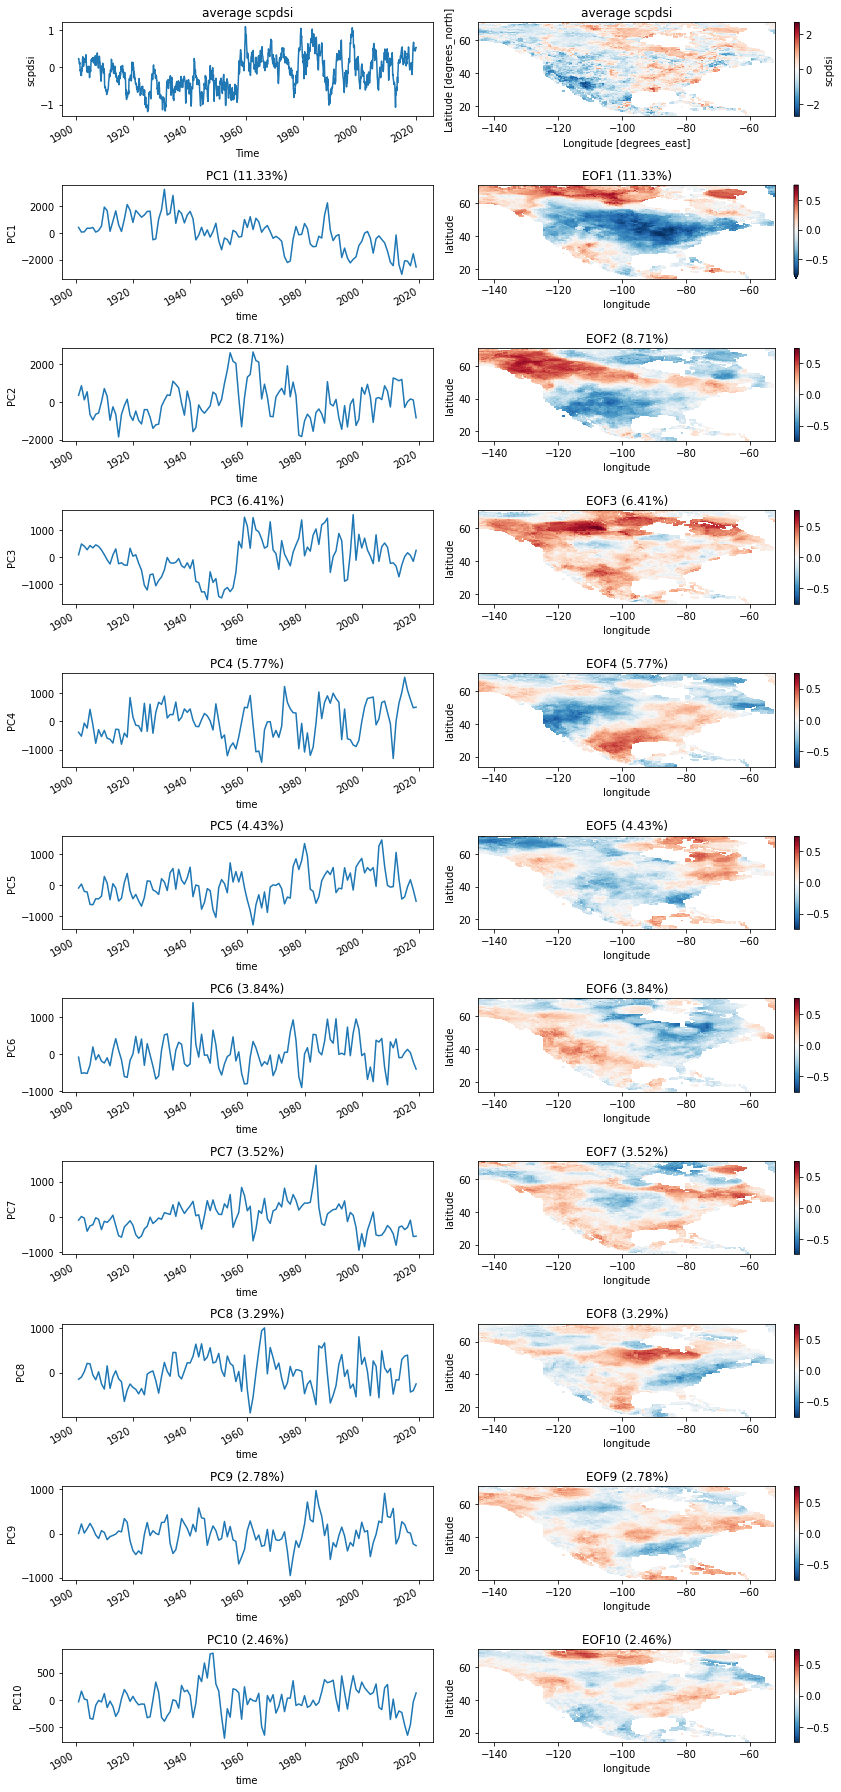

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1021: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


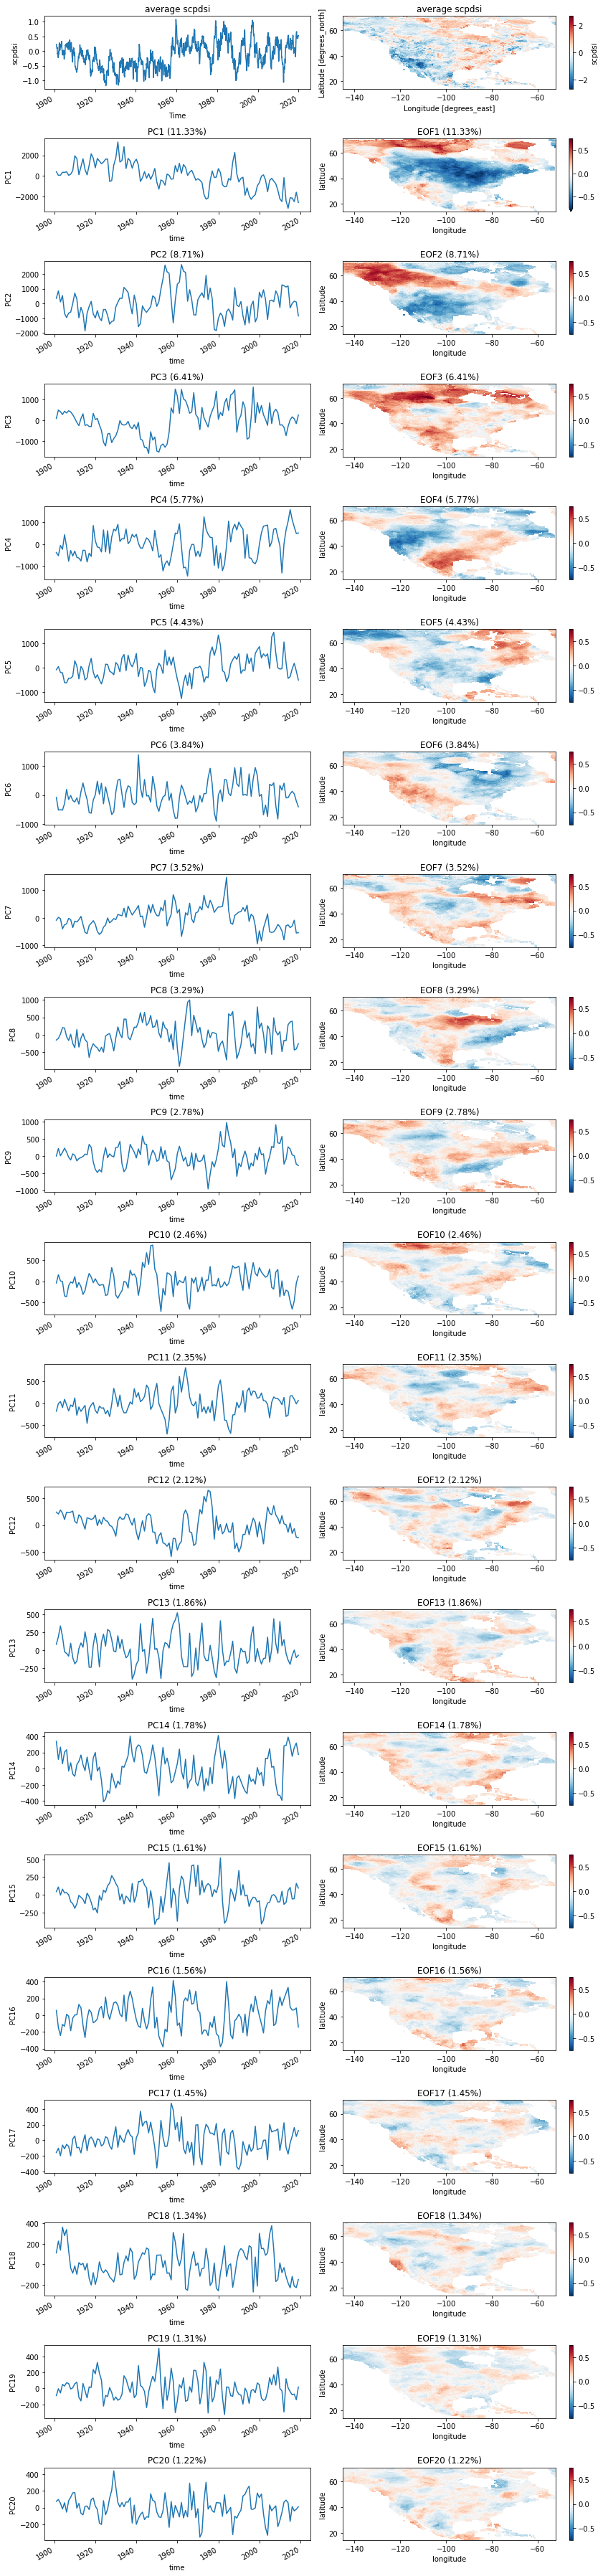

In [ ]:
pca, eofs, pcs, evfs, eigvals = eof_an(df_data, ds_n, n = 10, scale_type = 2, pca_type = None)

#20 паттернов EOF, объясняет 69.14% дисперсии
pca20, eofs20, pcs20, evfs20, eigvals20 = eof_an(df_data, ds_n, n = 20, scale_type = 2, pca_type = None)

list_regr = []
list_regr20 = []
post_list_regr = []

#Добавил другие размеры групп
ll = [None, 4, 5, 6, 7]

for tl in ll:
  type_parts = tl #выбор единицы деления (пятилетки, шестилетки и тд.) 
  if tl == None:
    a = [None]
  else:
    a = list(range(0,type_parts))

  #наборы для регрессиии
  for t_use_norm in (True, False):
    for t_use_aug in (True, False):
      for a_m in a:
        postf = 'regr_norm' + str(t_use_norm) + '_aug' + str(t_use_aug)  + '_use' + str(type_parts) + str(a_m)
        var_n = 'tr_t' + postf + ', tr_l' + postf + ', te_t' + postf + ', te_l' + postf + ', v_r' + postf
        exec(var_n + ' = sta_split(trsgi_values, pcs, use_norm = ' + str(t_use_norm) + ", type_op = 'regr', use_aug = " + str(t_use_aug) + ', use5 = ' + str(a_m) + ", type_parts = " + str(type_parts) + ')')
        exec('list_regr.append([' + var_n + '])')

        #20 EOF
        exec(var_n + ' = sta_split(trsgi_values, pcs20, use_norm = ' + str(t_use_norm) + ", type_op = 'regr', use_aug = " + str(t_use_aug) + ', use5 = ' + str(a_m) + ", type_parts = " + str(type_parts) + ')')
        exec('list_regr20.append([' + var_n + '])')

        post_list_regr.append(postf)

# Обучение моделей

**Нотация моделей (названия переменных, в которые сохранены модели, указаны над графиком):** <br><br>
*regr* - регрессионная  <br>
*normTrue/normFalse* - нормированные или ненормированные данные<br>
*augTrue/augFalse* - синтетически расширенный набор данных или нет<br>
*use<число>* - ширина единицы деления (четырехлетки, пятилетки и тд.)<br>
*useX<число>* - использовалось ли разделение оп X-леткам плюс число смещения отсчета (*useNoneNone* - не использовалось)<br>
eof0 - eof не использовались<br>
eof1 - использовались eof<br>
eof2 - использовались примитивы eof<br>

In [ ]:
#################################################################
'''Фильтр настроен на запуск обучения всех моделей, таблицу для них можно скачать из pickle'''
#################################################################

# Добавил возможность тренировать модели не всех типов. Для этого нужно исключить из списка те или иные параметры
norm = ['True','False'] 
#norm = ['True'] 
aug = ['True','False']
#aug = ['False']
#use_01 = [None, 4, 5, 6, 7] #размер единицы деления
use_01 = [None] #размер единицы деления
#use_02 = [None, 0, 1, 2, 3, 4, 5, 6] #начальное смещение
use_02 = [None] #начальное смещение
eof = [0,1,2]
#eof = [0]

a_arr_regr = filt_arr('regr', norm, aug, use_01, use_02, eof)

d = {'Name': [], 'params': [], 'loss': [], 'val_loss': [], 'test_loss': []}
df_regr = pd.DataFrame(data=d)
df_regr20 = pd.DataFrame(data=d)

df_regr_batch = pd.DataFrame(data=d)
df_regr20_batch = pd.DataFrame(data=d)


for li_m in range(len(post_list_regr)):
  m_stri = post_list_regr[li_m]
  for uE in list(range(3)):
    print(m_stri + '_useEOF' + str(uE))
    if m_stri + '_useEOF' + str(uE) in a_arr_regr:

      print('10 EOF')
      exec('df_regr, ' + m_stri + '_useEOF' + str(uE) + ' = train_model(eofs, df_regr, list_regr, post_list_regr, li_m, type_m = "regr", useEOF = ' + str(uE) + ',use_batch_norm = False)')
      print('20 EOF')
      exec('df_regr20, ' + m_stri + '_useEOF' + str(uE) + '_20EOF' + ' = train_model(eofs20, df_regr20, list_regr20, post_list_regr, li_m, type_m = "regr", useEOF = ' + str(uE) + ',use_batch_norm = True)')

      print('10 EOF, batch-norm')
      exec('df_regr_batch, ' + m_stri + '_useEOF' + str(uE) + '_batch = train_model(eofs, df_regr_batch, list_regr, post_list_regr, li_m, type_m = "regr", useEOF = ' + str(uE) + ',use_batch_norm = False)')
      print('20 EOF, batch-norm')
      exec('df_regr20_batch, ' + m_stri + '_useEOF' + str(uE) + '_20EOF' + '_batch = train_model(eofs20, df_regr20_batch, list_regr20, post_list_regr, li_m, type_m = "regr", useEOF = ' + str(uE) + ',use_batch_norm = True)')



'''
save_pickle('drive/MyDrive/df_regr_batchnorm.pickle', df_regr_batch)
save_pickle('drive/MyDrive/df_regr_batchnorm20.pickle', df_regr20_batch)
save_pickle('drive/MyDrive/df_regr.pickle', df_regr)
save_pickle('drive/MyDrive/df_regr20.pickle', df_regr20)'''

Чтение таблиц из pickle

In [73]:
df_regr_batch = read_pickle('drive/MyDrive/df_regr_batchnorm.pickle')
df_regr20_batch = read_pickle('drive/MyDrive/df_regr_batchnorm20.pickle')
df_regr = read_pickle('drive/MyDrive/df_regr.pickle')
df_regr20 = read_pickle('drive/MyDrive/df_regr20.pickle')

#Добавил в таблицы поля с разницей значений между тестом и значениями с тренировки
df_regr20_batch['test_loss-loss'] = df_regr20_batch.apply(lambda row: diff(row, 'test_loss-loss'), axis=1)
df_regr20_batch['test_loss-val_loss'] = df_regr20_batch.apply(lambda row: diff(row, 'test_loss-val_loss'), axis=1)

df_regr['test_loss-loss'] = df_regr.apply(lambda row: diff(row, 'test_loss-loss'), axis=1)
df_regr['test_loss-val_loss'] = df_regr.apply(lambda row: diff(row, 'test_loss-val_loss'), axis=1)

df_regr_batch['test_loss-loss'] = df_regr_batch.apply(lambda row: diff(row, 'test_loss-loss'), axis=1)
df_regr_batch['test_loss-val_loss'] = df_regr_batch.apply(lambda row: diff(row, 'test_loss-val_loss'), axis=1)

df_regr20['test_loss-loss'] = df_regr20.apply(lambda row: diff(row, 'test_loss-loss'), axis=1)
df_regr20['test_loss-val_loss'] = df_regr20.apply(lambda row: diff(row, 'test_loss-val_loss'), axis=1)

# Оценка результатов

Ниже выбраны записи из таблицы без использования X-леток

In [74]:
norm = ['True','False']
aug = ['True','False']
#use_01 = [None, 4, 5, 6, 7]
use_01 = [None]
#use_02 = [None, 0, 1, 2, 3, 4, 5, 6]
use_02 = [None]
eof = [0,1,2]

a_arr_regr = filt_arr('regr', norm, aug, use_01, use_02, eof)

df_regr1 = df_regr[df_regr['Name'].isin(a_arr_regr)]
df_regr_batch1 = df_regr_batch[df_regr_batch['Name'].isin(a_arr_regr)]
df_regr20_batch1 = df_regr20_batch[df_regr20_batch['Name'].isin(a_arr_regr)]
df_regr201 = df_regr20[df_regr20['Name'].isin(a_arr_regr)]


Горизонтальные бары

In [ ]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

plt.rcParams["figure.figsize"] = [50, 20]

df_regr1.plot.barh(x= 'Name')
df_regr_batch1.plot.barh(x= 'Name')
df_regr20_batch1.plot.barh(x= 'Name')
df_regr201.plot.barh(x= 'Name')

Те же значения, но в виде цветной таблицы <br>
Заметно приемущество моделей без использования EOF

In [76]:
df_regr1.style.background_gradient(cmap="Blues")

,Name,params,loss,val_loss,test_loss,test_loss-loss,test_loss-val_loss
0,regr_normTrue_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 70}",337575.250000,346354.310000,301425.880000,-36149.370000,-44928.430000
1,regr_normTrue_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 70}",350128.500000,358949.880000,307488.470000,-42640.030000,-51461.410000
2,regr_normTrue_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 70}",318300.220000,299837.530000,312674.060000,-5626.160000,12836.530000
3,regr_normTrue_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",384497.720000,336116.340000,353539.380000,-30958.340000,17423.040000
4,regr_normTrue_augFalse_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 7}",378831.380000,397384.190000,373868.970000,-4962.410000,-23515.220000
5,regr_normTrue_augFalse_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 7}",411176.690000,333187.000000,369668.090000,-41508.600000,36481.090000
6,regr_normFalse_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 70}",313988.410000,300525.500000,434991.440000,121003.030000,134465.940000
7,regr_normFalse_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 70}",324230.970000,345115.620000,443818.340000,119587.370000,98702.720000
8,regr_normFalse_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 70}",306285.590000,284977.530000,419686.720000,113401.130000,134709.190000
9,regr_normFalse_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",349063.840000,357792.880000,445142.380000,96078.540000,87349.500000


In [77]:
df_regr_batch1.style.background_gradient(cmap="Blues")

,Name,params,loss,val_loss,test_loss,test_loss-loss,test_loss-val_loss
0,regr_normTrue_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 70}",344818.220000,315796.440000,306264.160000,-38554.060000,-9532.280000
1,regr_normTrue_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 70}",361585.530000,317412.810000,307221.220000,-54364.310000,-10191.590000
2,regr_normTrue_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 70}",315225.970000,291918.660000,315089.160000,-136.810000,23170.500000
3,regr_normTrue_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",368645.380000,410264.660000,355733.810000,-12911.570000,-54530.850000
4,regr_normTrue_augFalse_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 7}",365874.310000,421951.620000,368487.440000,2613.130000,-53464.180000
5,regr_normTrue_augFalse_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 7}",380408.410000,393055.090000,377126.440000,-3281.970000,-15928.650000
6,regr_normFalse_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 70}",310200.310000,312695.720000,435401.250000,125200.940000,122705.530000
7,regr_normFalse_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 70}",329628.470000,331147.840000,447743.280000,118114.810000,116595.440000
8,regr_normFalse_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 70}",329992.750000,313763.780000,437671.560000,107678.810000,123907.780000
9,regr_normFalse_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",356078.190000,340737.410000,450903.280000,94825.090000,110165.870000


In [78]:
df_regr201.style.background_gradient(cmap="Blues")

,Name,params,loss,val_loss,test_loss,test_loss-loss,test_loss-val_loss
0,regr_normTrue_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 140}",185911.940000,197900.280000,223778.640000,37866.700000,25878.360000
1,regr_normTrue_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 140}",187230.940000,181404.590000,226843.140000,39612.200000,45438.550000
2,regr_normTrue_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 140}",184822.330000,189725.530000,226178.620000,41356.290000,36453.090000
3,regr_normTrue_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",207238.810000,225315.920000,210891.590000,3652.780000,-14424.330000
4,regr_normTrue_augFalse_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 7}",210054.500000,206771.360000,205025.140000,-5029.360000,-1746.220000
5,regr_normTrue_augFalse_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 7}",187894.980000,228963.190000,208011.720000,20116.740000,-20951.470000
6,regr_normFalse_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 140}",201440.880000,176223.700000,185418.000000,-16022.880000,9194.300000
7,regr_normFalse_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 140}",202039.910000,190728.590000,186888.270000,-15151.640000,-3840.320000
8,regr_normFalse_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 140}",177686.830000,186677.140000,170746.340000,-6940.490000,-15930.800000
9,regr_normFalse_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",231968.300000,183567.810000,167307.890000,-64660.410000,-16259.920000


In [79]:
df_regr20_batch1.style.background_gradient(cmap="Blues")

,Name,params,loss,val_loss,test_loss,test_loss-loss,test_loss-val_loss
0,regr_normTrue_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 140}",184950.410000,202196.160000,224270.720000,39320.310000,22074.560000
1,regr_normTrue_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 140}",185021.140000,183002.000000,226576.230000,41555.090000,43574.230000
2,regr_normTrue_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 140}",184897.800000,187980.620000,225507.420000,40609.620000,37526.800000
3,regr_normTrue_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",206025.910000,225485.750000,205968.500000,-57.410000,-19517.250000
4,regr_normTrue_augFalse_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 7}",214592.700000,195192.340000,204494.830000,-10097.870000,9302.490000
5,regr_normTrue_augFalse_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 7}",202726.500000,240157.940000,210575.000000,7848.500000,-29582.940000
6,regr_normFalse_augTrue_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 140}",197233.020000,192576.980000,184828.190000,-12404.830000,-7748.790000
7,regr_normFalse_augTrue_useNoneNone_useEOF1,"{'verbose': 0, 'epochs': 200, 'steps': 140}",199168.770000,196380.380000,186239.920000,-12928.850000,-10140.460000
8,regr_normFalse_augTrue_useNoneNone_useEOF2,"{'verbose': 0, 'epochs': 200, 'steps': 140}",182660.310000,169409.520000,172881.380000,-9778.930000,3471.860000
9,regr_normFalse_augFalse_useNoneNone_useEOF0,"{'verbose': 0, 'epochs': 200, 'steps': 7}",212648.810000,250349.440000,166661.360000,-45987.450000,-83688.080000


Выбираем для каждой из 4 лучшую по показателю test_loss из таблицы и делаем на них предикт

In [80]:
pred_res = regr_normTrue_augTrue_useNoneNone_useEOF0.predict(np.asarray(trsgi_values))
pred_res_batch = regr_normTrue_augTrue_useNoneNone_useEOF0_batch.predict(np.asarray(trsgi_values))
pred_res20 = regr_normFalse_augFalse_useNoneNone_useEOF1_20EOF.predict(np.asarray(trsgi_values))
pred_res_batch20 = regr_normFalse_augFalse_useNoneNone_useEOF1_20EOF_batch.predict(np.asarray(trsgi_values))

Визуальная проверка предсказаний регрессионной модели для определенного года.

In [ ]:
font = {
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.rcParams["figure.figsize"] = [10, 10]

regr_graph_check(year = 10, 
                 base_year = 1901, 
                 df_data = df_data, 
                 ds_n = ds_n, 
                 pca = pca20,
                 pcs = pred_res20, 
                 eofs = eofs20, 
                 eigvals = eigvals20,
                 type_f = 'Both',
                 scale_type = 2)

Рассчет коэффициента корреляции между реальными и предсказанными значениями для определенного года.
Также приведены гистограммы по реальным и предсказанным значениям, тесты на нормальность (normaltest и тест Колмогорова-Смирнова), и коэффициенты корреляции Пирсона и Спирмана <br><br>
Значения коэффициентов корреляции выше у моделей с 20 EOF, а также у моделей, построенных с использованием batch-нормализации

In [91]:
#Для вывода картинок нужно убрать параметр type_ret
corr, corr_s = corr_coef_year(year = 10, 
                 base_year = 1901, 
                 df_data = df_data, 
                 ds_n = ds_n, 
                 pca = pca,
                 pcs = pred_res, 
                 eofs = eofs, 
                 eigvals = eigvals,
                 scale_type = 2,
                 type_ret = 'Mute')

corr_batch, corr_s_batch = corr_coef_year(year = 10, 
                 base_year = 1901, 
                 df_data = df_data, 
                 ds_n = ds_n, 
                 pca = pca,
                 pcs = pred_res_batch, 
                 eofs = eofs, 
                 eigvals = eigvals,
                 scale_type = 2,
                 type_ret = 'Mute')

corr_20, corr_s_20 = corr_coef_year(year = 10, 
                 base_year = 1901, 
                 df_data = df_data, 
                 ds_n = ds_n, 
                 pca = pca20,
                 pcs = pred_res20, 
                 eofs = eofs20, 
                 eigvals = eigvals20,
                 scale_type = 2,
                 type_ret = 'Mute')

corr_20_batch, corr_s_20_batch = corr_coef_year(year = 10, 
                 base_year = 1901, 
                 df_data = df_data, 
                 ds_n = ds_n, 
                 pca = pca20,
                 pcs = pred_res_batch20, 
                 eofs = eofs20, 
                 eigvals = eigvals20,
                 scale_type = 2,
                 type_ret = 'Mute')



print(corr, corr_s)
print(corr_batch, corr_s_batch)
print(corr_20, corr_s_20)
print(corr_20_batch, corr_s_20_batch)

(0.0683907119455297, 7.166213808392858e-13) SpearmanrResult(correlation=0.05887896260485236, pvalue=6.562799683887911e-10)
(0.11576508565274872, 4.2793998610944605e-34) SpearmanrResult(correlation=0.1100130968614597, pvalue=6.180619666180476e-31)
(0.3393073082020663, 3.869138423370676e-294) SpearmanrResult(correlation=0.355713594172321, pvalue=0.0)
(0.34633329668488333, 3.607063858355777e-307) SpearmanrResult(correlation=0.36443539450055196, pvalue=0.0)


In [ ]:
#аналогично для пикселя
corr, corr_s = corr_coef_pixel(str_lat = '70.75',
                str_lon = '-71.25',
                 base_year = 1901, 
                 df_data = df_data, 
                 ds_n = ds_n, 
                 pca = pca,
                 pcs = pred_res, 
                 eofs = eofs, 
                 eigvals = eigvals,
                 scale_type = 2,
                 type_ret = 'Mute')
print(corr, corr_s)